In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# > ****File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [2]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [20]:
sum(df['CryoSleep'].isna())

217

In [4]:
df['CryoSleep'] = df['CryoSleep'].replace({True: 1, False: 0})


In [5]:
df['Transported'] = df['Transported'].replace({True: 1, False: 0})


In [6]:
set([i.split("/")[2] for i in df.Cabin.values if type(i)!=float])
#sorted([int(i.split("/")[1]) for i in df.Cabin.values if type(i)!=float])[::-1]

{'P', 'S'}

HomePlanet: {'Earth', 'Europa', 'Mars', nan}
{1,2,3,4}

In [7]:
set(df['HomePlanet'])

{'Earth', 'Europa', 'Mars', nan}

In [8]:
df['HomePlanet'].replace('Earth', 1, inplace=True)
df['HomePlanet'].replace('Europa', 2, inplace=True)
df['HomePlanet'].replace('Mars', 3, inplace=True)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,2.0,0.0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,1.0,0.0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,2.0,0.0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,2.0,0.0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,1.0,0.0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2.0,0.0,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0
8689,9278_01,1.0,1.0,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0
8690,9279_01,1.0,0.0,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1
8691,9280_01,2.0,0.0,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0


Destination: {'55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan}
{1,2,3,4}

In [9]:
set(df['Destination'])

{'55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan}

In [10]:
df['Destination'].replace('55 Cancri e', 1, inplace=True)
df['Destination'].replace('PSO J318.5-22', 2, inplace=True)
df['Destination'].replace('TRAPPIST-1e', 3, inplace=True)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,2.0,0.0,B/0/P,3.0,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,1.0,0.0,F/0/S,3.0,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,2.0,0.0,A/0/S,3.0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,2.0,0.0,A/0/S,3.0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,1.0,0.0,F/1/S,3.0,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2.0,0.0,A/98/P,1.0,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0
8689,9278_01,1.0,1.0,G/1499/S,2.0,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0
8690,9279_01,1.0,0.0,G/1500/S,3.0,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1
8691,9280_01,2.0,0.0,E/608/S,1.0,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0


In [24]:
df['VIP'] = df['VIP'].replace({True: 1, False: 0})
df


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,2,0,2,3,39,0,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,1,0,6,3,24,0,109.0,9.0,25.0,549.0,44.0,1
2,0003_01,2,0,1,3,58,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,2,0,1,3,33,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,1,0,6,3,16,0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2,0,1,1,41,1,0.0,6819.0,0.0,1643.0,74.0,0
8689,9278_01,1,1,7,2,18,0,0.0,0.0,0.0,0.0,0.0,0
8690,9279_01,1,0,7,3,26,0,0.0,0.0,1872.0,1.0,0.0,1
8691,9280_01,2,0,5,1,32,0,0.0,1049.0,0.0,353.0,3235.0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   float64
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   float64
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 950.9+ KB


0       2
1       6
2       1
3       1
4       6
       ..
8688    1
8689    7
8690    7
8691    5
8692    5
Name: Cabin, Length: 8693, dtype: Int64

In [13]:
df['Cabin'] = df['Cabin'].str.split('/').str[0]

In [14]:
set(df['Cabin'])

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan}

letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10}

In [15]:
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df['Cabin'] = df['Cabin'].map(letter_to_int)

In [16]:
del df['Name']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   float64
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   float64
 4   Destination   8511 non-null   float64
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 883.0+ KB


Now we have 11 attribute to work with and they all are numeric


In [17]:
df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP']] = df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP']].astype('Int64')

In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   Int64  
 2   CryoSleep     8476 non-null   Int64  
 3   Cabin         8494 non-null   Int64  
 4   Destination   8511 non-null   Int64  
 5   Age           8514 non-null   Int64  
 6   VIP           8490 non-null   Int64  
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   int64  
dtypes: Int64(6), float64(5), int64(1), object(1)
memory usage: 933.9+ KB


Now We can go to filling every null and nan cell in our dataframe

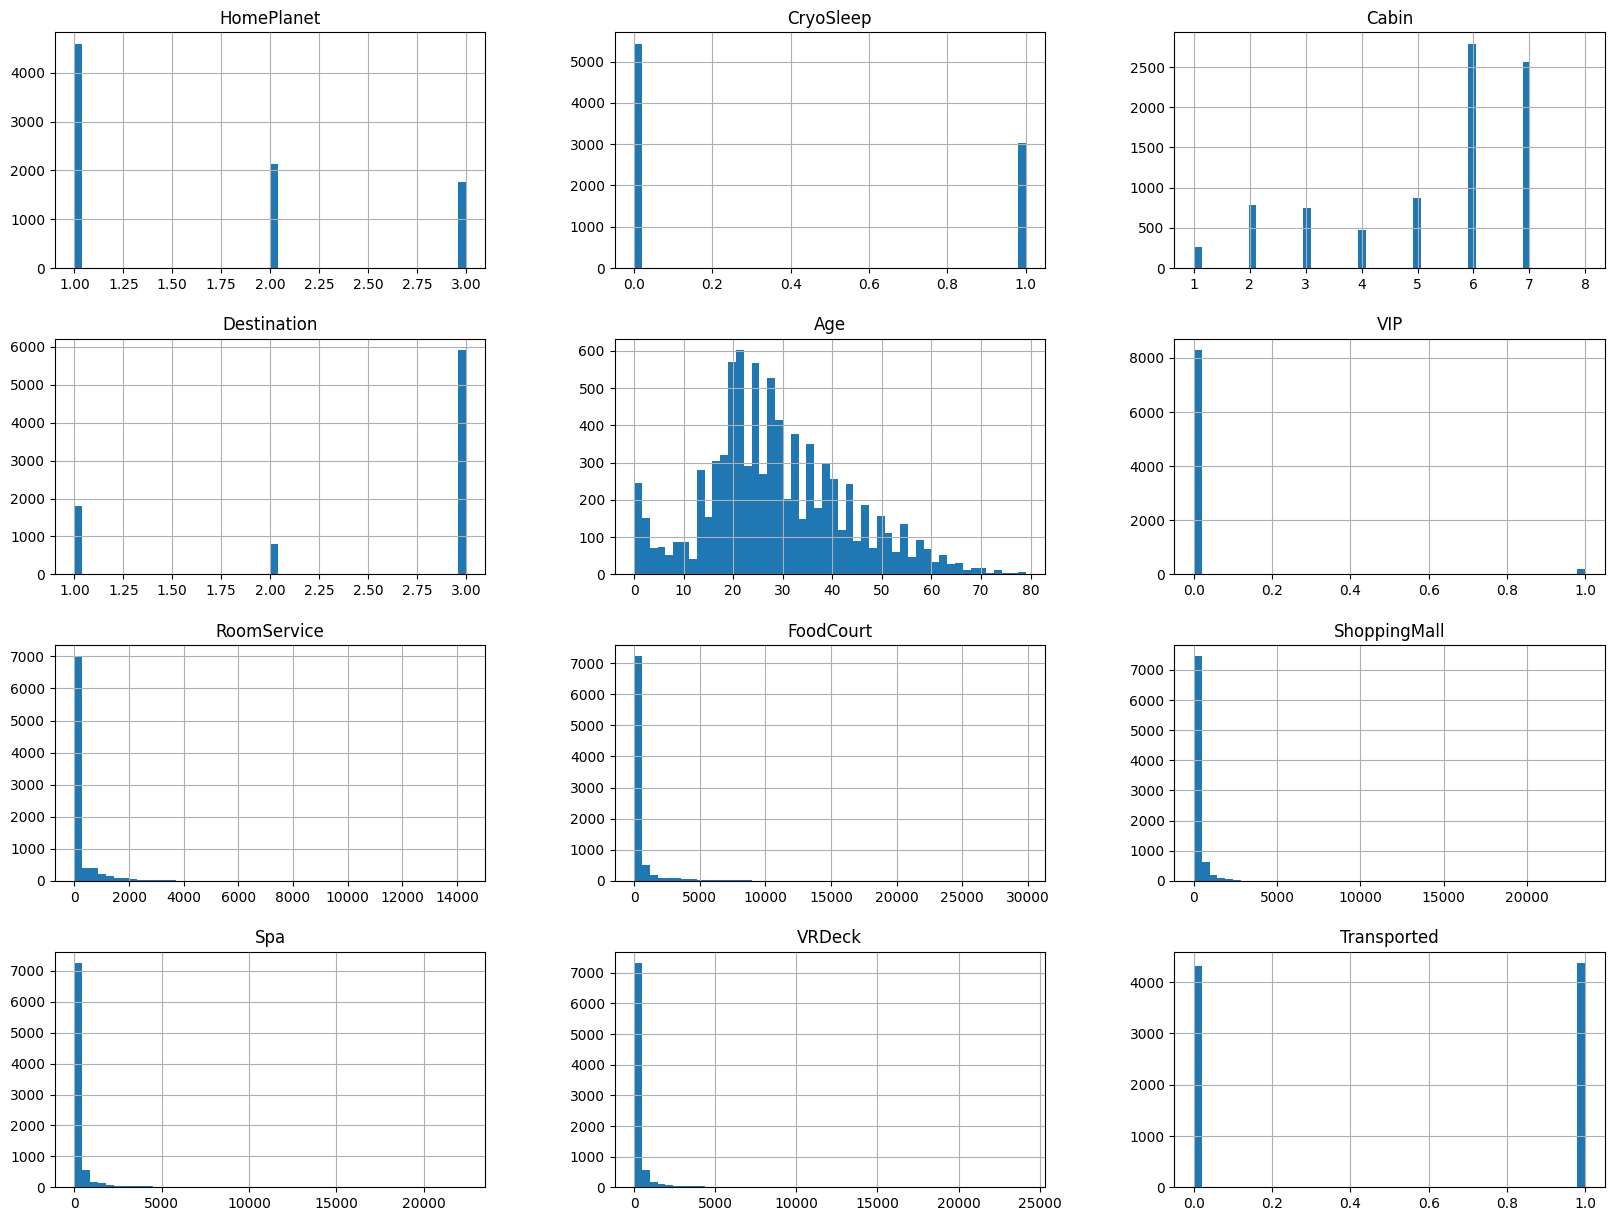

In [19]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

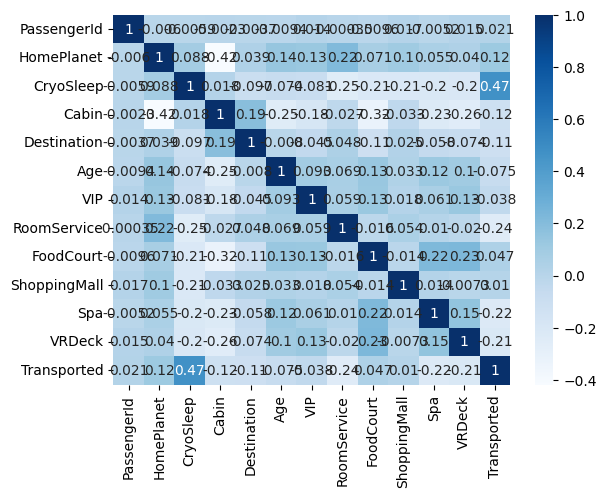

In [63]:
import seaborn as sb
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [60]:
df.groupby("Transported").mean()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Transported,,,,,,,,,,,,
0,inf,1.570311,0.131779,5.513994,2.574201,29.922858,0.029175,389.266066,382.615930,167.566217,564.382666,543.629822
1,inf,1.75883,0.581227,5.099813,2.394074,27.748834,0.017782,63.098021,532.691984,179.829972,61.675531,69.148131


<Axes: xlabel='CryoSleep'>

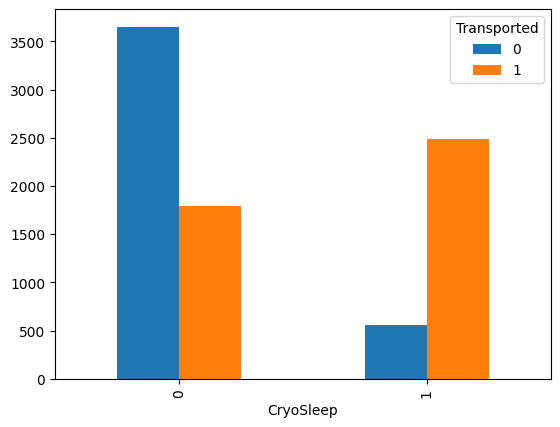

In [61]:
pd.crosstab(df.CryoSleep,df.Transported).plot(kind='bar')

In [69]:
df["HomePlanet"].fillna(df["HomePlanet"].mode()[0],inplace=True)
df["Destination"].fillna(df["Destination"].mode()[0],inplace=True)
df["Cabin"].fillna(df["Cabin"].mode()[0],inplace=True)
df["CryoSleep"].fillna(df["CryoSleep"].mode()[0],inplace=True)
df["VIP"].fillna(df["VIP"].mode()[0],inplace=True)
df["Age"].fillna(int(df["Age"].mean()),inplace=True)
df["RoomService"].fillna(df["RoomService"].mean(),inplace=True)
df["FoodCourt"].fillna(df["FoodCourt"].mean(),inplace=True)
df["ShoppingMall"].fillna(df["ShoppingMall"].mean(),inplace=True)
df["Spa"].fillna(df["Spa"].mean(),inplace=True)
df["VRDeck"].fillna(df["VRDeck"].mean(),inplace=True)
df.VIP = np.where(df.VIP,1,0)
df.CryoSleep = np.where(df.CryoSleep,1,0)


In [74]:
#No Nan, Null or empty cell
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   Int64  
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8693 non-null   Int64  
 4   Destination   8693 non-null   Int64  
 5   Age           8693 non-null   Int64  
 6   VIP           8693 non-null   int64  
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   int64  
dtypes: Int64(4), float64(5), int64(3), object(1)
memory usage: 917.0+ KB


In [75]:
# Calculate mean
df['Mean_luxury'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)

# Calculate median
df['Median_luxury'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].median(axis=1)

In [79]:
df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,Mean_luxury,Median_luxury
0,0001_01,2,0,2,3,39,0,0,0.0,0.0
1,0002_01,1,0,6,3,24,0,1,147.2,44.0
2,0003_01,2,0,1,3,58,1,0,2076.6,49.0
3,0003_02,2,0,1,3,33,0,0,1035.2,371.0
4,0004_01,1,0,6,3,16,0,1,218.2,151.0
...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2,0,1,1,41,1,0,1707.2,74.0
8689,9278_01,1,1,7,2,18,0,0,0.0,0.0
8690,9279_01,1,0,7,3,26,0,1,374.6,0.0
8691,9280_01,2,0,5,1,32,0,0,927.4,353.0


In [85]:
df['Spender_Mean'] = np.where(df.Mean_luxury > 0, 1,0)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,Mean_luxury,Median_luxury,Spender_Mean
0,0001_01,2,0,2,3,39,0,0,0.0,0.0,0
1,0002_01,1,0,6,3,24,0,1,147.2,44.0,1
2,0003_01,2,0,1,3,58,1,0,2076.6,49.0,1
3,0003_02,2,0,1,3,33,0,0,1035.2,371.0,1
4,0004_01,1,0,6,3,16,0,1,218.2,151.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2,0,1,1,41,1,0,1707.2,74.0,1
8689,9278_01,1,1,7,2,18,0,0,0.0,0.0,0
8690,9279_01,1,0,7,3,26,0,1,374.6,0.0,1
8691,9280_01,2,0,5,1,32,0,0,927.4,353.0,1


In [84]:
df = df.drop(columns=['Spender'])
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,Mean_luxury,Median_luxury,Spender_Mean
0,0001_01,2,0,2,3,39,0,0,0.0,0.0,0
1,0002_01,1,0,6,3,24,0,1,147.2,44.0,1
2,0003_01,2,0,1,3,58,1,0,2076.6,49.0,1
3,0003_02,2,0,1,3,33,0,0,1035.2,371.0,1
4,0004_01,1,0,6,3,16,0,1,218.2,151.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2,0,1,1,41,1,0,1707.2,74.0,1
8689,9278_01,1,1,7,2,18,0,0,0.0,0.0,0
8690,9279_01,1,0,7,3,26,0,1,374.6,0.0,1
8691,9280_01,2,0,5,1,32,0,0,927.4,353.0,1


In [86]:
df['Spender_Median'] = np.where(df.Median_luxury > 0, 1,0)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,Mean_luxury,Median_luxury,Spender_Mean,Spender_Median
0,0001_01,2,0,2,3,39,0,0,0.0,0.0,0,0
1,0002_01,1,0,6,3,24,0,1,147.2,44.0,1,1
2,0003_01,2,0,1,3,58,1,0,2076.6,49.0,1,1
3,0003_02,2,0,1,3,33,0,0,1035.2,371.0,1,1
4,0004_01,1,0,6,3,16,0,1,218.2,151.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,2,0,1,1,41,1,0,1707.2,74.0,1,1
8689,9278_01,1,1,7,2,18,0,0,0.0,0.0,0,0
8690,9279_01,1,0,7,3,26,0,1,374.6,0.0,1,0
8691,9280_01,2,0,5,1,32,0,0,927.4,353.0,1,1


3738